finished loading centerlines
finished calculating dem and slope along centerline
finished calculating strength along centerline


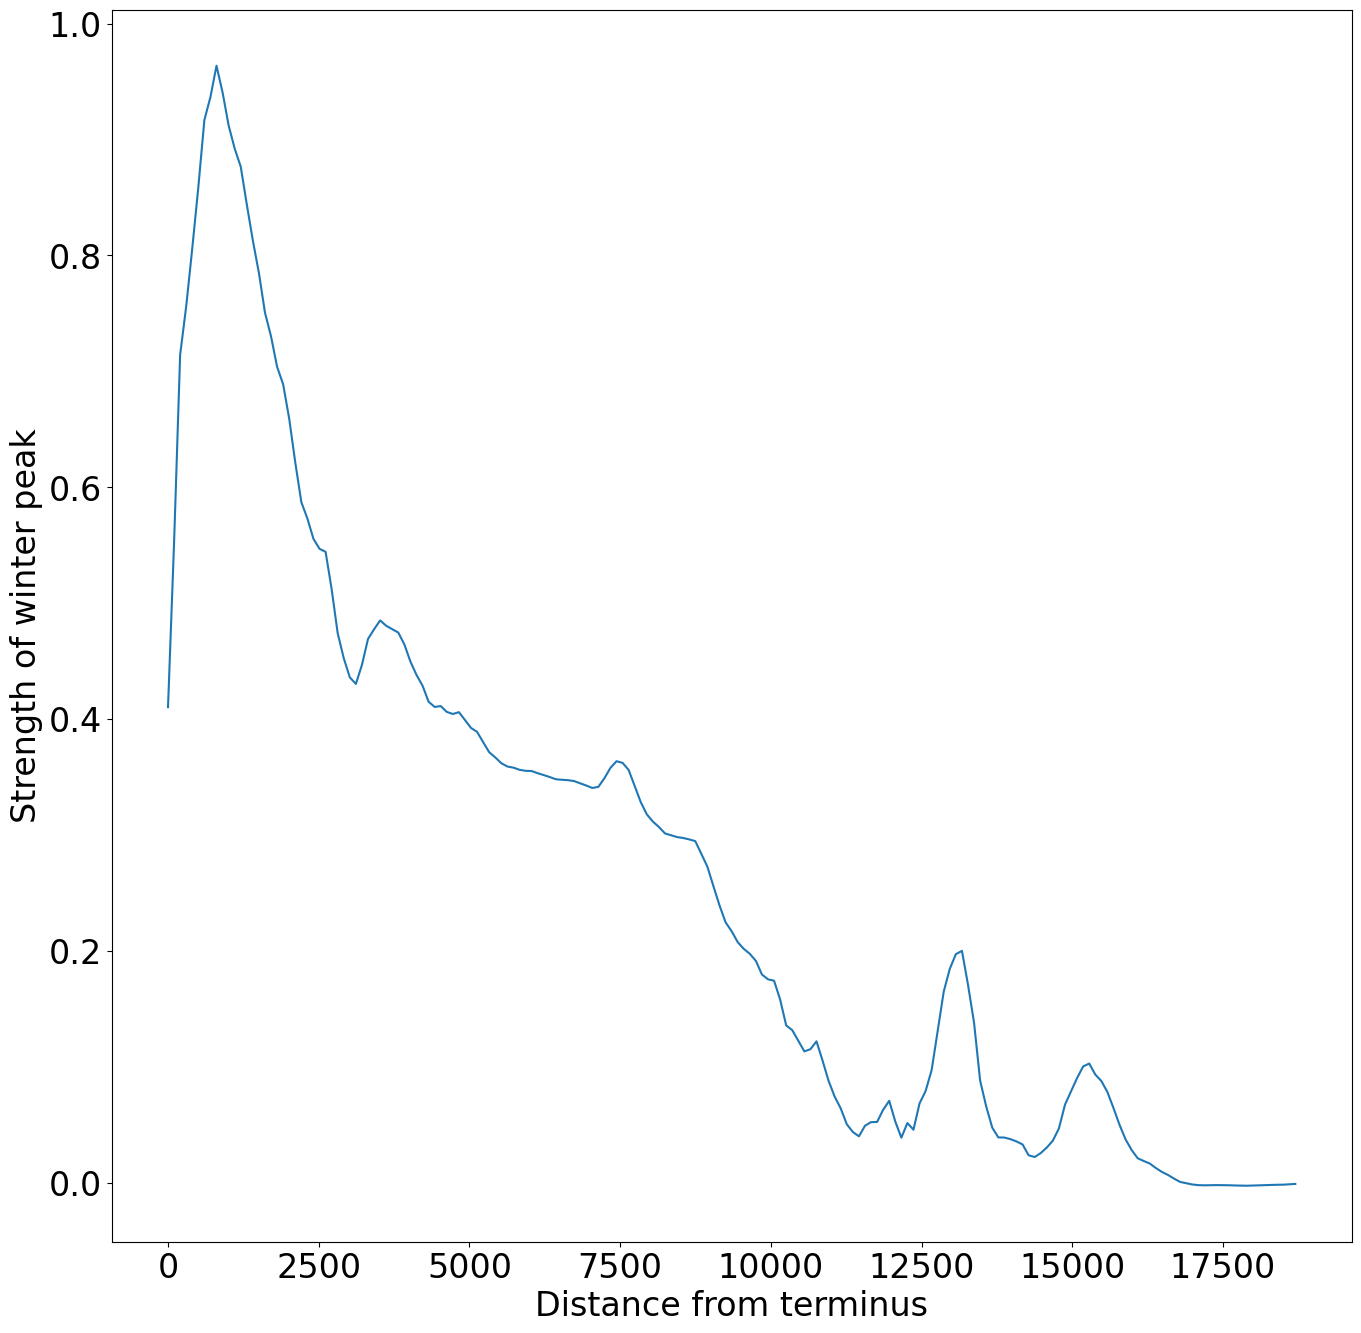

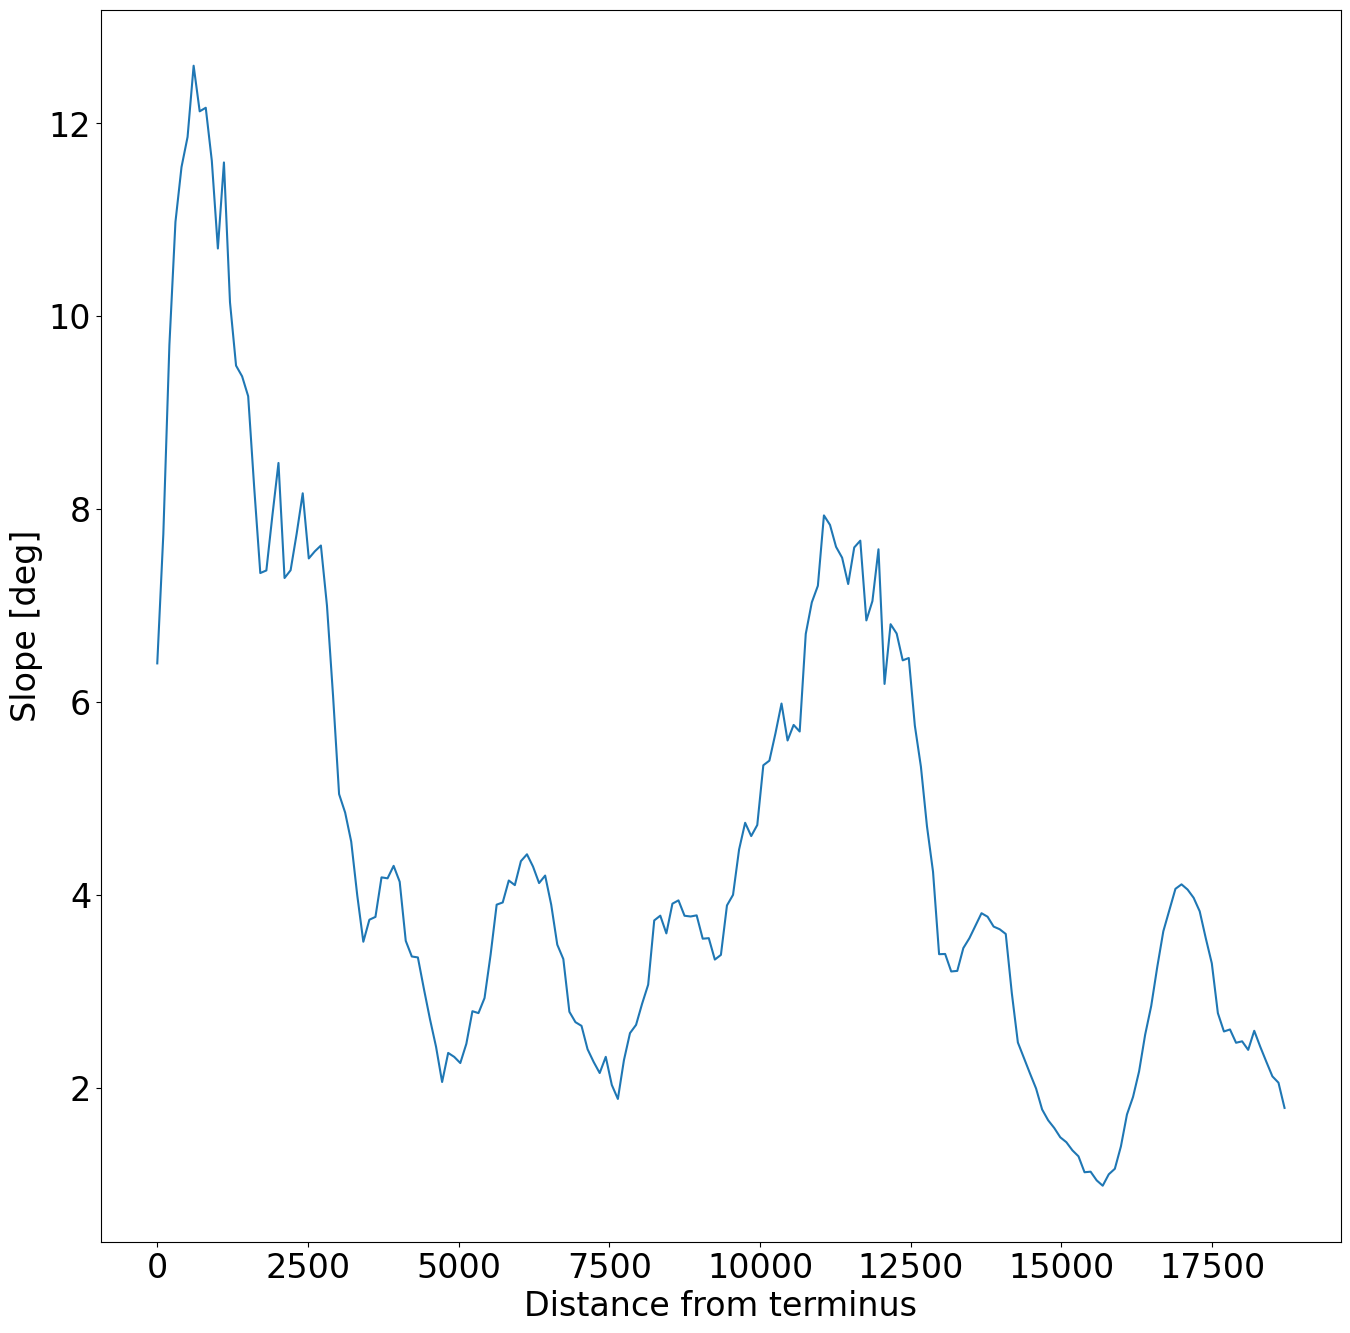

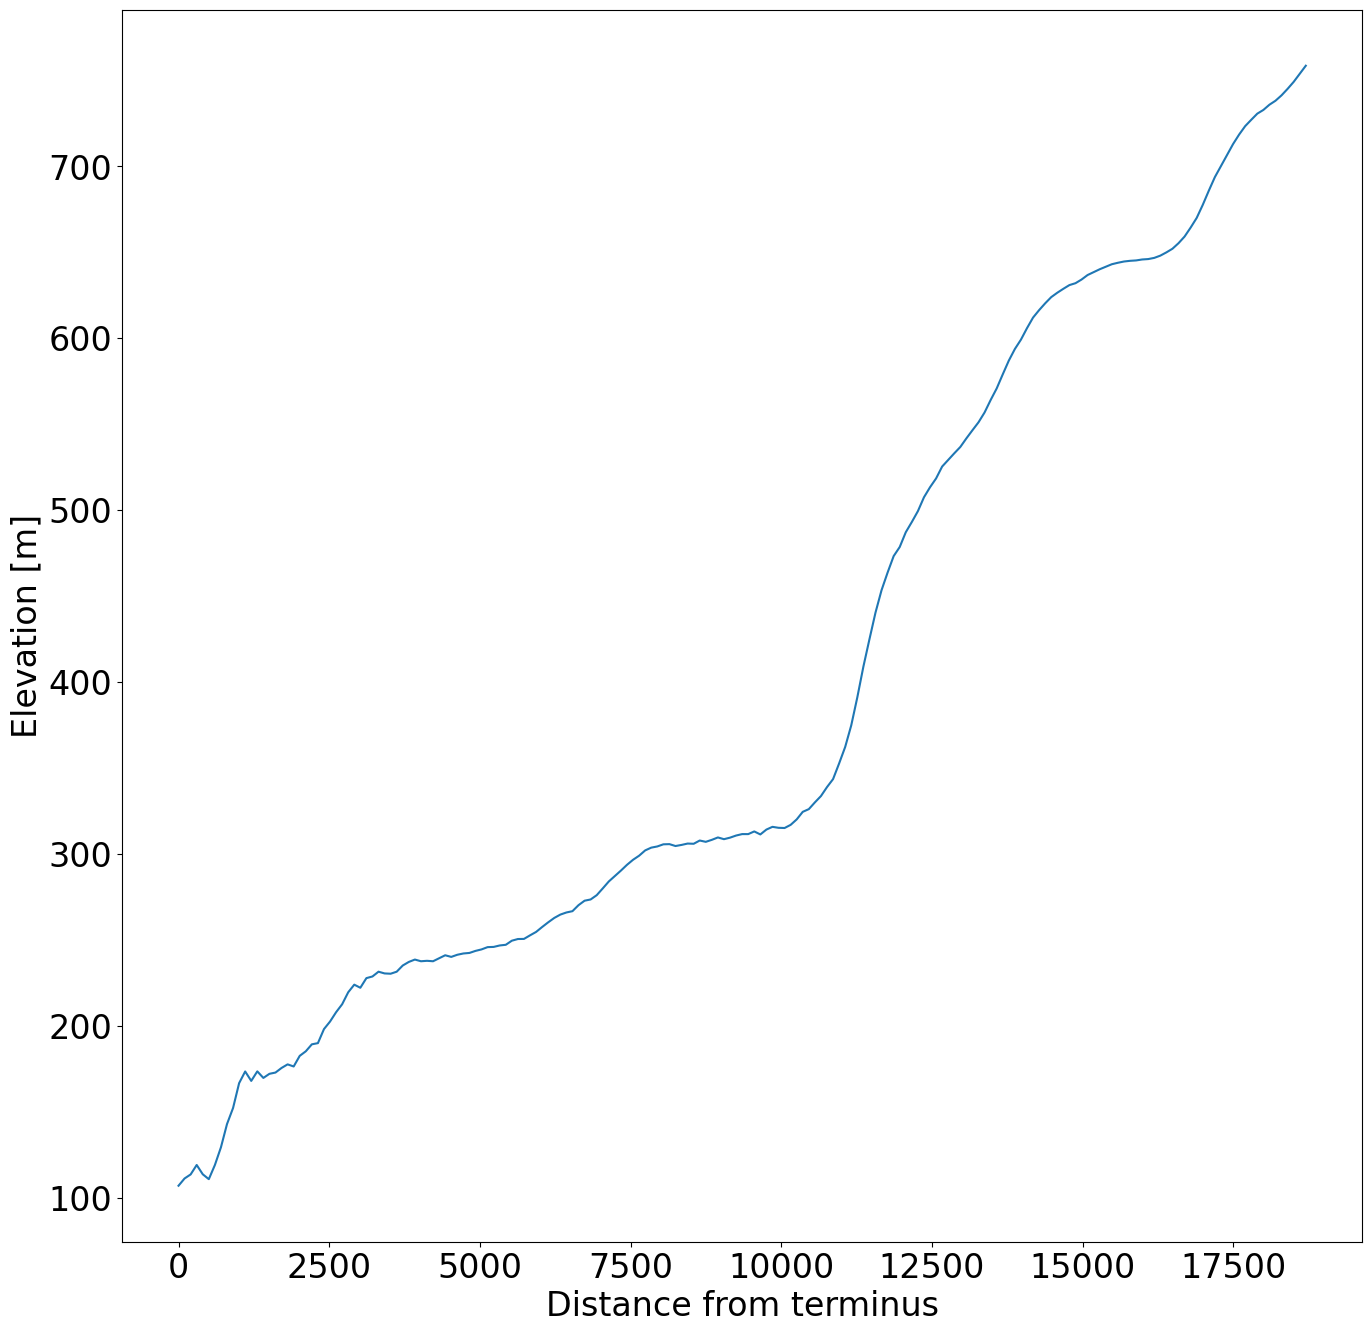

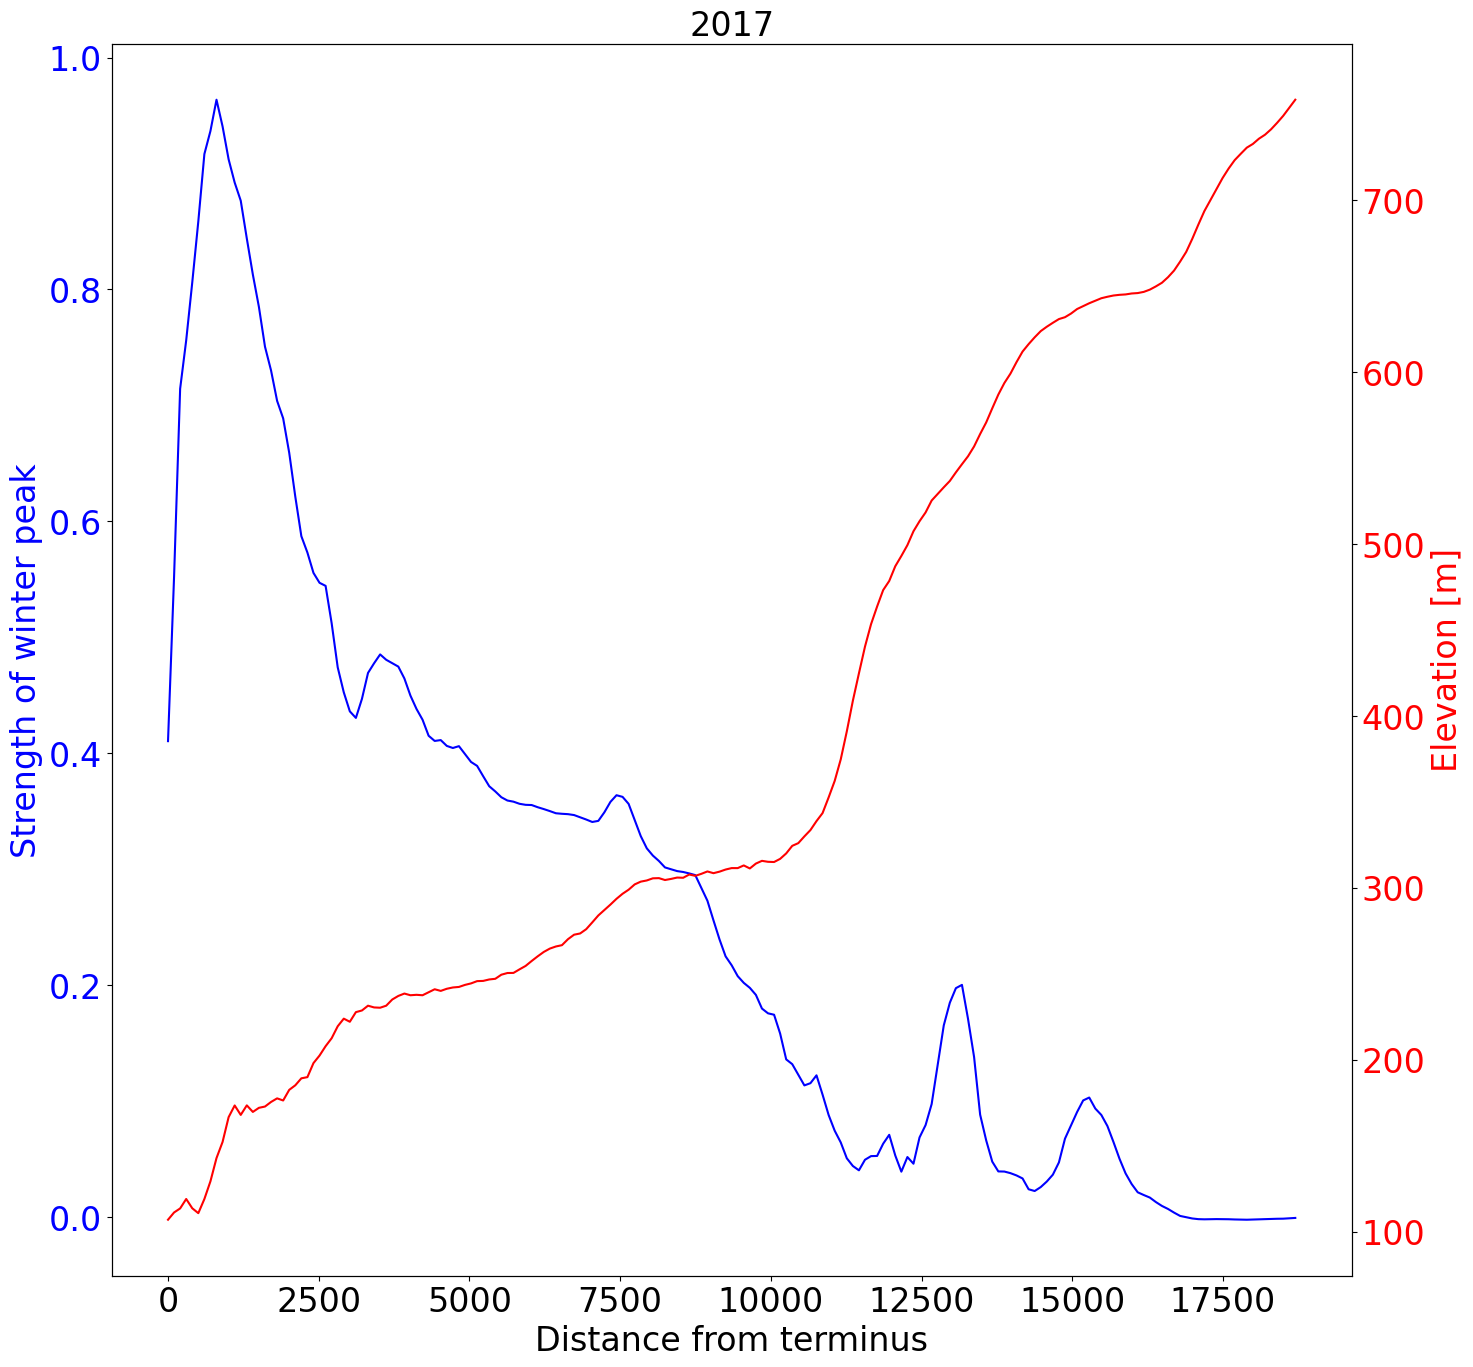

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray
import scipy
from scipy.signal import savgol_filter
import xarray
from tqdm import tqdm
import rasterio as rio
import affine
import os
import elevation
import imageio.v2 as imageio
from matplotlib.colors import BoundaryNorm
import geopandas as gpd
from pyproj import Transformer
import matplotlib.colors as mcolors

########################
# load centerline

points = pd.read_csv('centerline_points_100m.csv')
x, y =points.X.to_numpy(), points.Y.to_numpy()

#distance from terminus along centerline 
d = np.linspace(100*len(x), 0, len(x))

print('finished loading centerlines')

########################

# load DEM
    
# Open the GeoTIFF file
with rio.open('ifsar_hubbardDEM_reproj.tif') as src:
    # Convert centerline coordinates to pixel indices
    i, j = rio.transform.rowcol(src.transform, x, y)

    # Read the raster data
    data = src.read(1)  # Assuming a single band image
    
    dem_centerline = data[i, j]

    # Calculate the resolution (pixel size) of the DEM
    resolution = src.res[0]  # Assuming square pixels
    
    # Compute gradients using finite differences
    dz_dx, dz_dy = np.gradient(data, resolution)

    # Calculate slope magnitude
    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    slope_centerline = np.degrees(slope_rad[i,j])   
    
    n = 10
    slope_centerline = np.convolve(np.ones(n)/n, slope_centerline, mode="same")
    
# Combine target_x_idx, target_y_idx, and slope into a DataFrame
df1 = pd.DataFrame({'x': x, 'y': y, 'slope': slope_centerline})
df2 = pd.DataFrame({'x': x, 'y': y, 'dem': dem_centerline})
# Write the DataFrame to a CSV file
df1.to_csv('slope_along_centerline.csv')
df2.to_csv('dem_along_centerline.csv')

print('finished calculating dem and slope along centerline')

########################

ds = xarray.load_dataset("../Hubbard_5eminus5.nc")
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear
xx, yy = np.meshgrid(ds.x, ds.y)

years = 2017

for i, year in enumerate([years]):

    winter_mask = np.logical_or(
        np.logical_and(ds.month >= 11, ds.year == year),
        np.logical_and(ds.month <= 2, ds.year == year+1)
    )
    
    winter_velocities = ds.v[winter_mask, :, :]
    winter_peak = winter_velocities.max(dim='time')

    middle_mask = np.logical_and(
        np.logical_and(ds.month >= 2.05, ds.month <= 4),
        ds.year == year+1,
    )
    middle_velocities = ds.v[middle_mask, :, :]
    min = middle_velocities.min(dim='time')

    summer_mask = np.logical_and(
        np.logical_and(ds.month >= 4, ds.month <= 6),
        ds.year == year+1,
    )
    summer_velocities = ds.v[summer_mask, :, :]
    summer_peak = summer_velocities.max(dim='time')

    ###### calculate strength of double peaks 
    
    mask = (winter_peak < min) | (summer_peak < 500)
    
    strength = (winter_peak - min)
    #strength = np.where(mask, 0, strength)

########################
# get strength along centerline

#initialize arrays
strength_centerline = np.zeros((len(x)))

# find indices along centerline 
for i in range(len(x)):
    # get indices of coordinates closest to points of interest
    target_x_idx = np.abs(xx[:, :] - x[i]).argmin(axis = 1)
    target_y_idx= np.abs(yy[:, :] - y[i]).argmin(axis = 0)
    
     # Extract the slope value closest to the target coordinates
    strength_centerline[i] = strength[target_y_idx[0], target_x_idx[0]]

#normalize and smooth
strength_centerline =  strength_centerline/np.max(strength_centerline)
n = 5
strength_centerline = np.convolve(np.ones(n)/n, strength_centerline, mode="same")
 
print('finished calculating strength along centerline')

########################
# make figures 
fs = 24 #font size

########################
# strength along centerline

# make figures 
fig, ax0 = plt.subplots(figsize=(16, 16))
ax0.plot(d, strength_centerline)
ax0.set_xlabel('Distance from terminus', fontsize=fs)
ax0.set_ylabel('Strength of winter peak', fontsize=fs)
ax0.tick_params(axis='both', which='major', labelsize=fs)
plt.savefig(f'strength_centerline_{years}.png')

########################
# slope along centerline

fig, ax1 = plt.subplots(figsize=(16, 16))
ax1.plot(d, slope_centerline)
ax1.set_xlabel('Distance from terminus', fontsize=fs)
ax1.set_ylabel('Slope [deg]', fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)
plt.savefig('slope_centerline.png')

########################
# slope along centerline

fig, ax2 = plt.subplots(figsize=(16, 16))
ax2.plot(d, dem_centerline)
ax2.set_xlabel('Distance from terminus', fontsize=fs)
ax2.set_ylabel('Elevation [m]', fontsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)
plt.savefig('dem_centerline.png')

########################
# strength and dem along centerline

fig, ax3 = plt.subplots(figsize=(16, 16))

# first y axis 
ax3.plot(d, strength_centerline, 'b-')
ax3.set_xlabel('Distance from terminus', fontsize=fs)
ax3.set_ylabel('Strength of winter peak', fontsize=fs, color='b')
ax3.tick_params(axis='y', labelcolor='b', which='major', labelsize=fs)
ax3.tick_params(axis='x', which='major', labelsize=fs)

#second y-axis
ax4 = ax3.twinx()
ax4.plot(d, dem_centerline, 'r-')
ax4.set_ylabel('Elevation [m]', fontsize=fs, color='r')
ax4.tick_params(axis='y', labelcolor='r', which='major', labelsize=fs)
text_objs = plt.gcf().findobj(plt.Text)
for text_obj in text_objs:
    text_obj.set_fontsize(fs)
plt.title(f'{years}', fontsize=fs)
plt.show
plt.savefig(f'strength_dem_centerline_{years}.png')
